# IVE face recognition project

In this project...

## STEP 1: Load the images and process data

### 1.1 Retrieve the paths of the imagenes from the SQLite DB

In [1]:
import sqlite3

## Connect Python with the created DB

conn = sqlite3.connect('images.db')
cursor = conn.cursor()

## Retrieve the paths and labels

cursor.execute('SELECT file_path, label FROM images')
data = cursor.fetchall() # This part creates a List of tuples that contains (file_path, label)

cursor.execute("SELECT DISTINCT label FROM images")
unique_labels = [row[0] for row in cursor.fetchall()]
print(unique_labels)
print('vs')
print('Original query random index: ', data[45]) # There are different members in the dataset, the insertion worked properly

conn.close()

## Make separate lists

images_paths, labels = zip(*data)

['Gaeul', 'Leeseo', 'Liz', 'Rei', 'Wonyoung', 'Yujin']
vs
Original query random index:  ('C:\\Users\\lonel\\OneDrive\\Escritorio\\IVE face recognition\\Leeseo\\Le13.jpg', 'Leeseo')


### 1.2 Load images using OpenCV

In [2]:
import cv2

## Comprove if the filepaths are correct:

img = cv2.imread(images_paths[0]) # Load the first image
cv2.imshow('First image:', img) # Display the first image

cv2.waitKey(0)
cv2.destroyAllWindows() # All correct

### 1.3 Resizing & Normalization

The machine learning model will need that all the images are the same size so we are going to preprocess the images in the next code.

In [3]:
import numpy as np

## Define the size

img_size = (224, 224)

## Preprocess the images

def preprocess_image(img_path):
    img = cv2.imread(img_path) # Load images
    img = cv2.resize(img, img_size) # Resize tthe images
    img = img.astype('float32') / 255 # Normalize pixel values; pixel values scaled to [0,1] for better training performance

    return img

## Apply to all the images

processed_images = np.array([preprocess_image(path) for path in images_paths])

print('Shape of images', processed_images.shape)

Shape of images (198, 224, 224, 3)


### 1.4 Encode labels for model training

In [4]:
from sklearn.preprocessing import LabelEncoder

## Convert text labels to numbers

encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

## See the result

print('Original labels: ', labels[:6]) # It worked properly
print('Encoded labels: ', encoded_labels[:6])

print('Another index of the labes: ', labels[80])
print('Another index of the encoded labes: ', encoded_labels[80])

## Assure that all the members were correctly encoded

print('Labels unique values: ', np.unique(labels))
print('Encoded labels unique values: ', np.unique(encoded_labels))

Original labels:  ('Gaeul', 'Gaeul', 'Gaeul', 'Gaeul', 'Gaeul', 'Gaeul')
Encoded labels:  [0 0 0 0 0 0]
Another index of the labes:  Liz
Another index of the encoded labes:  2
Labels unique values:  ['Gaeul' 'Leeseo' 'Liz' 'Rei' 'Wonyoung' 'Yujin']
Encoded labels unique values:  [0 1 2 3 4 5]


## 2. Extract Features Using PCA

### 2.1 Convert the images into numeric data

In [ ]:
## Convert the np array with images into 1D array

N = processed_images.shape[0] # This extracts the number of images

processed_images_reshaped = processed_images.reshape(N, -1) # This part is necessary because of the type of data the PCA recives as an input

print('New shape', processed_images_reshaped.shape)

New shape (198, 150528)


### 2.2 Perfom the PCA

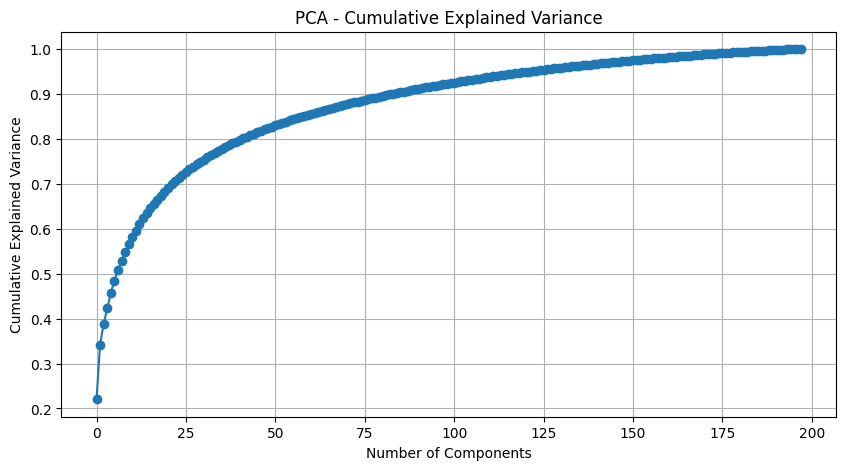

In [6]:
## Perform PCA

from sklearn.decomposition import PCA

pca = PCA()
pca.fit(processed_images_reshaped)

## Plot the variance ratio

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Cumulative Explained Variance')
plt.grid(True)
plt.show()

### 2.3 Data in 2d

New data:  [[  -0.91607255  -42.3543    ]
 [  10.533256    -64.61954   ]
 [  10.533256    -64.61952   ]
 [   3.3064735    23.385826  ]
 [  -9.969665    -25.15552   ]
 [  61.807346     34.88841   ]
 [   5.0704126    47.66618   ]
 [ -37.165184     84.44612   ]
 [  -1.4169793   -42.20522   ]
 [  70.11809      40.440613  ]
 [ -90.02594     -20.362068  ]
 [  93.18348      24.445772  ]
 [ -21.01727     -29.118313  ]
 [  72.28666      27.78693   ]
 [  54.900837    -43.34942   ]
 [  98.36255      47.382618  ]
 [  26.716936    -18.735483  ]
 [ -18.05952     -16.984474  ]
 [ -77.20157     -18.766882  ]
 [ -53.832375     30.49964   ]
 [  -9.616786     63.887505  ]
 [  89.02151      27.174152  ]
 [ -62.34837      22.17      ]
 [   1.2414345    10.621419  ]
 [ -21.847576      3.946504  ]
 [ -67.30665      67.938705  ]
 [  49.98817       2.2443182 ]
 [  -6.102487     18.01849   ]
 [ -13.721804     59.641327  ]
 [ -32.39714      18.254286  ]
 [  79.87008      70.00541   ]
 [ -55.682755     64.699066 

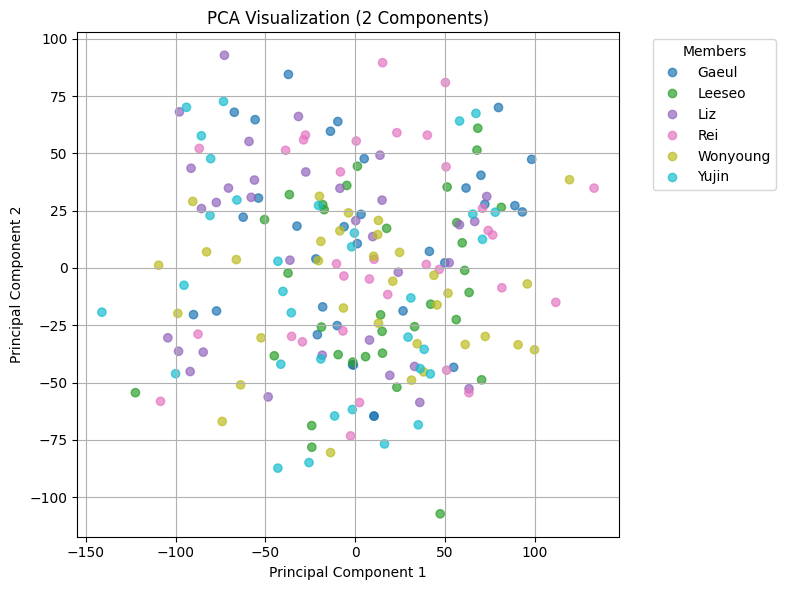

In [7]:
## Visualize Data in 2D

### Create a new PCA object

pca_2d = PCA(n_components=2)

images_2d = pca_2d.fit_transform(processed_images_reshaped)
print('New data: ', images_2d)
print('New data shape: ', images_2d.shape)

### Look the clusters

plt.figure(figsize=(8, 6))

# Scatter plot (colors by encoded_labels)
scatter = plt.scatter(images_2d[:, 0], images_2d[:, 1], c=encoded_labels, cmap='tab10', alpha=0.7)
unique_labes = np.unique(labels)
print('unique_labes', unique_labes)

# Legend: match handles to class names
handles, _ = scatter.legend_elements()
plt.legend(handles = handles,
           labels=unique_labels,
           title="Members",
           bbox_to_anchor=(1.05, 1),
           loc='upper left')

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization (2 Components)")
plt.grid(True)
plt.tight_layout()
plt.show()

## 3. Test the accuracy of the data and train model

### 3.1 Split the data into test and training sets

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images_2d,
                                                    encoded_labels,
                                                    test_size=0.2,
                                                    random_state=42) # This split the features into the X sets and the labels into the y sets

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (158, 2)
Test set shape: (40, 2)


### 3.2 Create a k means model

In [11]:
from sklearn.cluster import KMeans

km_model = KMeans(n_clusters=6, random_state=42) # Due to the number of members

# Fit the model

km_model.fit(X_train)

# Predict values

pred = km_model.predict(X_test)


### 3.3 Analize the performance of the model

Adjusted Rand Index (ARI): -0.009228065035886919


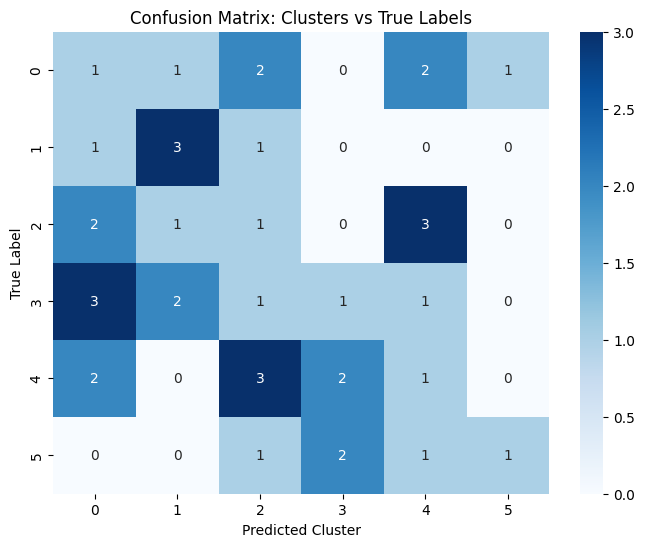

In [12]:
from sklearn.metrics import adjusted_rand_score, confusion_matrix

# ARI SCORE

ari_score = adjusted_rand_score(y_test, pred)

print("Adjusted Rand Index (ARI):", ari_score)

# CONFUSION MATRIX

import seaborn as sns

cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: Clusters vs True Labels")
plt.xlabel("Predicted Cluster")
plt.ylabel("True Label")
plt.show()

### 3.4 Interpretation of the results

As we can see in the ARI score, our model performs worse than if the try to classify each member by random and our Confusion Matrix confirms it but it isn't the only plot were we could see the problem, back in the point 2.3 we could see that the scatter have not a difined cluster so it was an .

That's why in the next point we will improve the quality of our clusters.

## 4. Improve the quality

### 4.1 Clean the data

In [ ]:
# Create a function to extract the vectors of each image

def vectors_extraction(images):
    X_features = []
    for image in images:
        img = image.astype('float32')

    img_preprocessed = preprocess_input(np.expand_dims(img, axis=0))